Using the final checkpoint of the baseline model (trained 30 epochs) and training an additional 10 epochs with DA. Note base script originates from https://github.com/atmguille/Violence-Detection-With-Human-Skeletons

In [1]:
try:
    import tensorflow as tf
except:
    !pip install tensorflow[and-cuda]

2023-12-04 07:39:25.324457: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 07:39:25.388383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 07:39:25.388435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 07:39:25.388473: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 07:39:25.399984: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
PATHS = ["/home/Datasets/RWF_Augmented/Video", "/home/Datasets/RWF_Augmented/Openpose"]

FRAME_FUNC = 'frame_diff'
# To use frame diff to weight t (current) or t+1
WEIGHT_CURRENT = True

In [3]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0:], 'GPU')
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2023-12-04 07:39:28.732217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22493 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-12-04 07:39:28.733204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22493 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:3d:00.0, compute capability: 8.6
2023-12-04 07:39:28.734017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22493 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:3e:00.0, compute capability: 8.6
2023-12-04 07:39:28.734830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22493 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:88:00.0, 

Number of devices: 4


Set seed

In [4]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [5]:
import numpy as np
import cv2

In [6]:
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

def load_videos(video_IDs: list, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)

    return videos

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [7]:
import gc
from tensorflow.keras import backend as K

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.paths = paths
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]
        input_videos = []
        
        for index, path in enumerate(self.paths):
            batch_IDs_full_path = [path+ID for ID in batch_IDs]

            videos = load_videos(batch_IDs_full_path, self.video_frames, self.video_width, 
                                         self.video_height, self.video_channels, self.dtype, self.normalize)
            
            input_videos.append(videos)
        
        labels = np.array([self.video_labels[ID] for ID in batch_IDs])
                    
        return input_videos, labels
            
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

## Videos to load

In [8]:
def get_slug_from_path(path):
    """
    Function to get slug from path
    slug must contain /train or /val because there are repeated names
    """
    # Try train index first
    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]

In [9]:
import glob

train_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/train/*/*')]
test_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}


train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=64, paths=PATHS)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10, paths=PATHS)

# Frame functions

In [10]:
import tensorflow.keras.backend as K

def tf_frame_diff(video):
    return video[1:] - video[:-1]

def tf_frame_dist(video):
    video_diff = tf_frame_diff(video)
    return K.sqrt(K.sum(K.square(video_diff), axis=-1, keepdims=True))

if WEIGHT_CURRENT:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(-video_diff)
        video_diff_next = tf.nn.relu(video_diff)
        video_diff_next_norm = K.sqrt(K.sum(K.square(video_diff_next), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_next_norm])
else:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(video_diff)
        video_diff_prev = tf.nn.relu(-video_diff)
        video_diff_prev_norm = K.sqrt(K.sum(K.square(video_diff_prev), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_prev_norm])
    
frame_func_dict = {'frame_diff': tf_frame_diff, 'frame_dist': tf_frame_dist, 'frame_diff_dist_combined': tf_frame_diff_dist_combined}
frame_func = frame_func_dict[FRAME_FUNC]

# ConvLSTM

In [11]:
with strategy.scope():
    inputs_raw = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
    inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

    inputs_diff = tf.keras.layers.Lambda(lambda video: tf.map_fn(frame_func, video))(inputs_raw)
    inputs_to_weight = inputs_openpose[:, :-1] if WEIGHT_CURRENT else inputs_openpose[:, 1:]

    inputs_diff_norm = tf.keras.layers.BatchNormalization()(inputs_diff)
    inputs_diff_time_info_weight = tf.keras.layers.ConvLSTM2D(filters=9, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='tanh')(inputs_diff_norm)

    convolutional_layer = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu')
    inputs_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer)(inputs_to_weight)

    inputs_openpose_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)

    inputs_weighted = tf.keras.layers.Add()([inputs_openpose_norm, inputs_diff_time_info_weight])

    x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_weighted)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

    x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dense(units=16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

    model = tf.keras.Model([inputs_raw, inputs_openpose], outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model = tf.keras.models.load_model('final_model.h5')
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# Load pretrained best model to continue training

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'augmented_best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[model_checkpoint_callback])

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-12-04 07:40:36.233684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 07:40:36.370055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 07:40:36.416285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 07:40:36.455172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 07:40:44.665112: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdc61131560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 07:40:44.665171: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-12-04 07:40:44.665223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-12-04 07:40:44.665232: I tensorflo

87/87 [==============================] - 1851s 21s/step - loss: 0.6285 - accuracy: 0.6816 - val_loss: 0.3774 - val_accuracy: 0.8650


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
87/87 [==============================] - 1618s 19s/step - loss: 0.4776 - accuracy: 0.7786 - val_loss: 0.4523 - val_accuracy: 0.8150
Epoch 3/10
87/87 [==============================] - 1609s 18s/step - loss: 0.4477 - accuracy: 0.7974 - val_loss: 0.5025 - val_accuracy: 0.7850
Epoch 4/10
87/87 [==============================] - 1599s 18s/step - loss: 0.4341 - accuracy: 0.8037 - val_loss: 0.3620 - val_accuracy: 0.8500
Epoch 5/10
87/87 [==============================] - 1730s 20s/step - loss: 0.4189 - accuracy: 0.8147 - val_loss: 0.4003 - val_accuracy: 0.8400
Epoch 6/10
87/87 [==============================] - 1786s 20s/step - loss: 0.4088 - accuracy: 0.8200 - val_loss: 0.4909 - val_accuracy: 0.8000
Epoch 7/10
87/87 [==============================] - 2581s 30s/step - loss: 0.3976 - accuracy: 0.8279 - val_loss: 0.3593 - val_accuracy: 0.8500
Epoch 8/10
87/87 [==============================] - 2024s 23s/step - loss: 0.3916 - accuracy: 0.8274 - val_loss: 0.3575 - val_accuracy: 0.8550

# Model performance

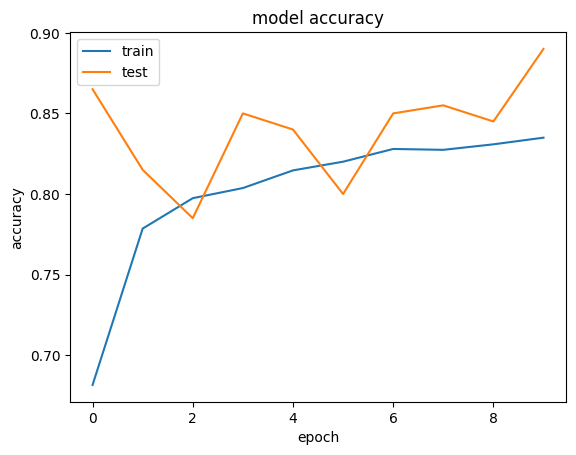

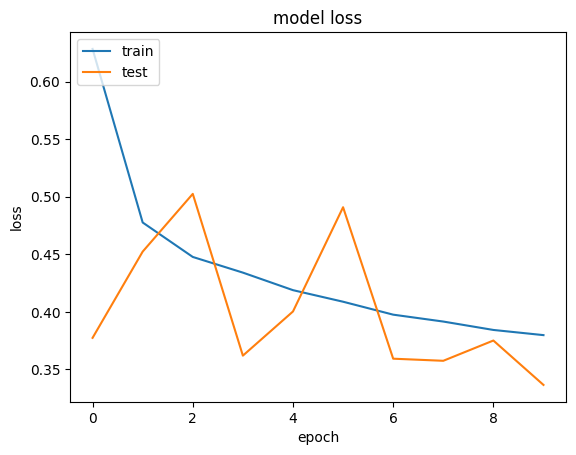

In [14]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()